In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ah_wryfb
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ah_wryfb
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0d2ab99cccbbc682722e708515fe9c4cfc50185a
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4716 sha256=a26baadd8b3c814ea9596d97be228d2c74d476bdbde79b5df36b31bf153b22e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmsuqypj/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
/bin/bash: line 1: cuda-install-

In [6]:
%%cuda --name lab_3.cu
#include <cublas_v2.h>
#include <malloc.h>
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <cstdlib>
#include <curand.h>
#include <stdio.h>
#include <time.h>
#include <iostream>
#include <ctime>
#pragma comment (lib, "cublas.lib")

//__device__ double atomicAdd(double* a, double b) { return b; }

__global__ void piCalcKernel(const double * A, const double * B, int * pi, int size) {
    int sum = 0;
    int idx = threadIdx.x + (blockIdx.x*blockDim.x);
    int thread_count = gridDim.x * blockDim.x;
    double temp;
    for (int i=idx; i<size; i += thread_count) {
      temp = A[i] * A[i] + B[i] * B[i];
      if (temp < 1) {
          sum ++;
      }
    }
    atomicAdd(pi, sum);
}

void GPU_fill_rand(double* A, int size) {
  curandGenerator_t prng;
  curandCreateGenerator(&prng, CURAND_RNG_PSEUDO_DEFAULT);
  curandSetPseudoRandomGeneratorSeed(prng, (unsigned long long) clock());
  curandGenerateUniformDouble(prng, A, size);
}


void check_calc(const double* A, const double* B, int size) {
  double temp;
  int sum = 0;
  for (int i = 0; i < size; i++) {
      temp = A[i] * A[i] + B[i] * B[i];
      //std:: cout << temp << "\n";
      if (temp < 1) {
          sum += 1;
      }
  }
  //std:: cout << sum << "\n";
  temp = ((double)(4 * sum)) / ((double)size);
  printf("Check PI = %f", temp);
}


int main() {
  int size;
  std::cin >> size;
  int GRID_SIZE = 4;
  int BLOCK_SIZE = 128;
  // Создаем массивы / выделяем память на CPU
  double* a = (double*)malloc(size * sizeof(double));
  double* b = (double*)malloc(size * sizeof(double));
  int* pi = (int*)malloc(sizeof(int));
  // Создаем массивы / выделяем память на GPU
  double* a_gpu;
  double* b_gpu;
  int* pi_gpu;
  cudaError_t cuerr = cudaMalloc(&a_gpu, size * sizeof(double));
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot allocate device array for A: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }

  cuerr = cudaMalloc(&b_gpu, size * sizeof(double));
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot allocate device array for B: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaMalloc((void **)&pi_gpu, sizeof(int));
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot allocate device array for PI: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }
  // Создание обработчиков событий
  cudaEvent_t start, stop;
  cuerr = cudaEventCreate(&start);
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot create CUDA start event: %s\n",
      cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaEventCreate(&stop);
    if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot create CUDA stop event: %s\n",
      cudaGetErrorString(cuerr));
    return 0;
  }


  // Заполняем массивы A и B на GPU рандомными значениями
  GPU_fill_rand(a_gpu, size);
  GPU_fill_rand(b_gpu, size);

  dim3 block = dim3 (BLOCK_SIZE, 1, 1);
  dim3 grid = dim3 (GRID_SIZE, 1);
  cudaEventRecord(start, 0);
  // Запуск ядра
  piCalcKernel<<< grid, block >>>(a_gpu, b_gpu, pi_gpu, size);
  cuerr = cudaGetLastError();
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot launch CUDA kernel: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  // Синхронизация устройств
  cuerr = cudaDeviceSynchronize();
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot synchronize CUDA kernel: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }
  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);
  float mmul_time = 0.0f;
  cudaEventElapsedTime(&mmul_time, start, stop);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);
  std::cout << size << std::endl;
  printf("...............\n");

  // Копирование матриц на CPU
  cudaMemcpy(a, a_gpu, size * sizeof(double), cudaMemcpyDeviceToHost);
  cudaMemcpy(b, b_gpu, size * sizeof(double), cudaMemcpyDeviceToHost);

  clock_t time_cpu;
  time_cpu = clock();
  //расчет cpu
  check_calc(a, b, size);
  time_cpu = clock() - time_cpu;


  // Копирование результата умножения на CPU
  cudaMemcpy(pi, pi_gpu, sizeof(int), cudaMemcpyDeviceToHost);
  std::cout << std::endl;
  std::cout << "pi = " << ((double)(4 * pi[0])) / ((double)size) << std::endl;

  mmul_time = mmul_time / 1000;
  printf("..............\n");
  printf("Mmul time GPU: %.4f \n", mmul_time);
  printf("Mmul time CPU: %.4f \n", (double) time_cpu / CLOCKS_PER_SEC);

  //Освобождение памяти GPU
  cudaFree(a_gpu);
  cudaFree(b_gpu);
  cudaFree(pi_gpu);
  //cudaFree(pi_global);
  // Освобождение памяти CPU
  free(a);
  free(b);
  free(pi);
  return 0;
}

'File written in /content/src/lab_3.cu'

In [7]:
!nvcc -o /content/src/lab_3 /content/src/lab_3.cu -lcurand -lcublas

In [13]:
!/content/src/lab_3

100000000
100000000
...............
Check PI = 3.141280
pi = 3.14128
..............
Mmul time GPU: 0.0748 
Mmul time CPU: 1.1584 


In [9]:
import numpy as np

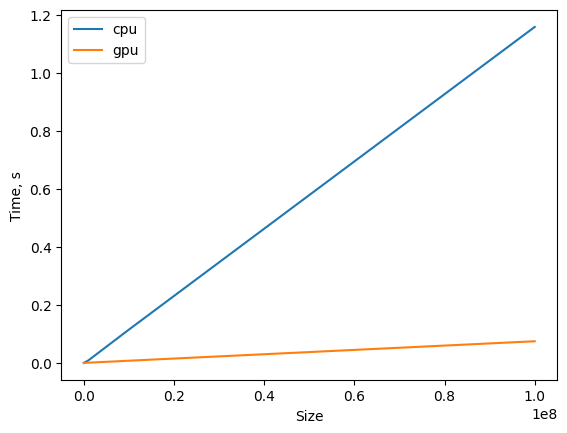

In [18]:
import matplotlib.pyplot as plt
x = [10000, 100000, 1000000, 10000000, 100000000]
cpu = [0.0001, 0.0008, 0.0086, 0.1149, 1.1584]
gpu = [0.0003, 0.0003, 0.0009, 0.0077, 0.0748]
plt.xlabel("Size")
plt.ylabel("Time, s")
plt.plot(x, cpu, label='cpu')
plt.plot(x, gpu, label='gpu')
plt.legend()
plt.show()

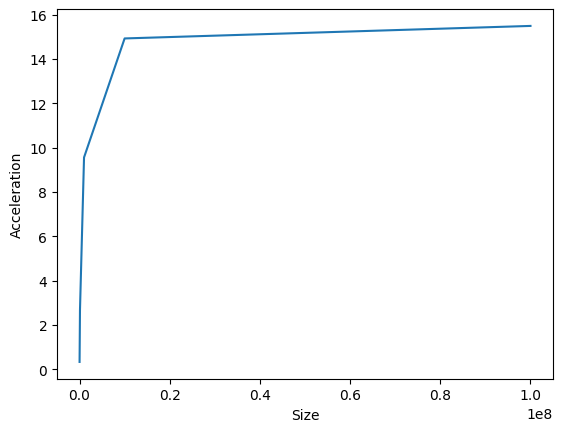

[0.33333333333333337, 2.666666666666667, 9.555555555555555, 14.922077922077921, 15.48663101604278]


In [16]:
a = [cpu[i] / gpu[i] for i in range(len(cpu))]
plt.xlabel("Size")
plt.ylabel("Acceleration")
plt.plot(x, a)
plt.show()
print(a)